# Autoencoders
- https://habr.com/ru/post/331382/

- https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [8]:
params = {
    "test_size": 0.33,
    "batch_size": 64,
    "num_workers": 0,
    "epochs": 20,
    "random_state": 42,
    "device": "cuda",
}

In [91]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from collections import defaultdict
from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms
from sklearn.manifold import TSNE

from copy import deepcopy
%matplotlib inline

In [3]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
def draw_loss(loss_list_train, loss_list_val):
    ##############Loss#############
    plt.figure(figsize=(15,6))
    plt.plot(loss_list_train, label='Train')
    plt.plot(loss_list_val, label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.show()

def visualize_tsne(vectors, labels):
    plt.figure(figsize=(15,8))
    for i in range(10):
        lab = labels[labels==i]
        vecs = vectors[labels==i]
        plt.scatter(vecs[:,0], vecs[:,1], cmap=lab, label=i)
    plt.legend()
    plt.title('Проекция латентных векторов в 2-мерное пространство')
    
def main_loop(train_dataloader, val_dataloader, model, criterion, optimizer, epochs, device):
    train_loss = []
    val_loss = []
    for epoch in range(1, epochs+1):
        # Обучаем
        epoch_loss = train(train_dataloader, model, criterion, optimizer, epoch, device)
        train_loss.append(epoch_loss)
        # Валидируемся
        epoch_loss = validate(val_dataloader, model, criterion, epoch, device)
        val_loss.append(epoch_loss)
        # Рисуем промежуточные реконструкции на валидационной выборке
        draw_epoch_result(val_dataloader, model)
    draw_loss(train_loss, val_loss)

In [98]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=48, dimy=48)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
attrs.shape, data.shape

((13143, 73), (13143, 48, 48, 3))

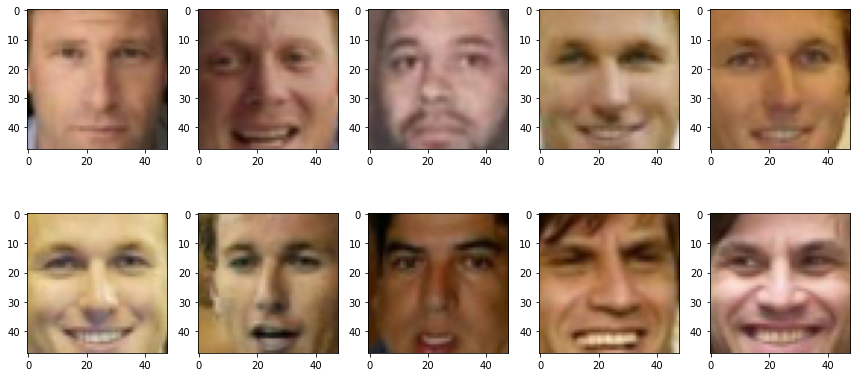

In [119]:
def visualize(idx=0, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        ax.ravel()[i].imshow(data[i])
    plt.tight_layout()
    plt.show()
visualize()

In [9]:
class Datasets(Dataset):
    def __init__(self, data, attrs, ret_attr=True):
        self.transform = self.transform_img()
        self.data = data
        self.attrs = np.array(attrs, dtype=np.float64)
        self.columns_of_attrs = attrs.columns
        self.ret_attr = ret_attr
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        img_np, attr = self.data[index], self.attrs[index]
        image = self.transform(image=img_np)["image"]
        if self.ret_attr:
            return image.type(torch.FloatTensor), attr
        return image
    
    def transform_img(self):
        return A.Compose(
            [
#                 A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ]
        )
    
train_imgs, val_imgs, train_attrs, val_attrs = train_test_split(data, attrs, test_size=params["test_size"], random_state=params["random_state"])
train_dataset = Datasets(train_imgs, train_attrs)
val_dataset = Datasets(val_imgs, val_attrs)
print('Validation len:', val_dataset.__len__(), 'Train len:', train_dataset.__len__())

train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'], pin_memory=False)
val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'], pin_memory=False)

Validation len: 4338 Train len: 8805


## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер.
###### Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

###### В обычном автоенкодере z_dim = 64 * 6 * 6

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid())
    
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [14]:
autoencoder = Autoencoder().to(params["device"])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())
# summary(autoencoder, (3, 48, 48))

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [15]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    for i, (image, attr) in enumerate(stream, start=1):
        image = image.to(device, non_blocking=False)
        optimizer.zero_grad()
        output, _ = model(image)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        metric_monitor.update("Loss", loss.item())
        running_loss += loss.item()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=False)
            output, _ = model(image)
            loss = criterion(output, image)
            metric_monitor.update("Loss", loss.item())
            running_loss += loss.item()
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    epoch_loss = running_loss/len(val_loader)
    return epoch_loss

def draw_epoch_result(val_loader, model, idx=0, samples=10, cols=5):
    images, _ = next(iter(val_loader))
    idxes = np.random.randint(0, len(images), samples//2)
    images = images[idxes,]
    model.eval()
    with torch.no_grad():
        recosntructions, _ = model(images.to(params["device"]))
    clear_output(wait=True)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples//2):
        ax.ravel()[i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.ravel()[i+samples//2].imshow(recosntructions[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.ravel()[i].set_title('Original')
        ax.ravel()[i+samples//2].set_title('Reconstructions')
    plt.tight_layout()
    plt.show()

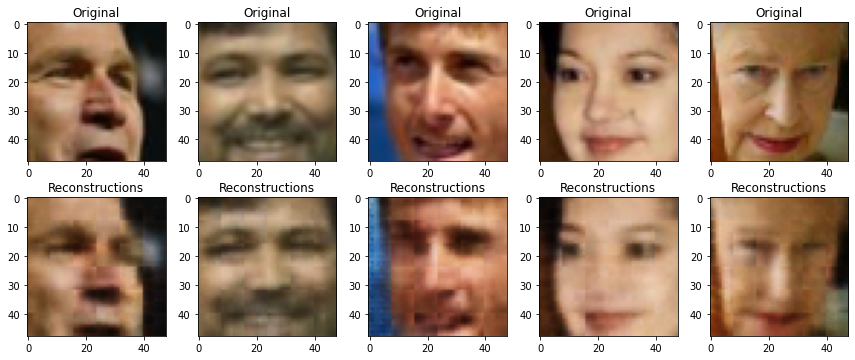

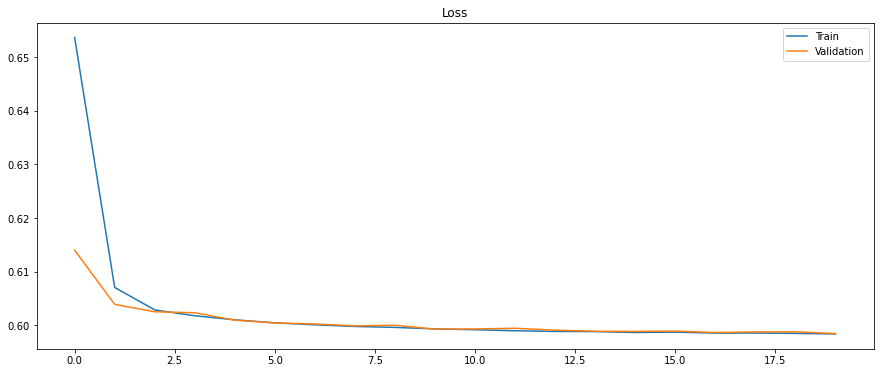

In [16]:
main_loop(train_dataloader, val_dataloader, autoencoder, criterion, optimizer, params["epochs"], params["device"])

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

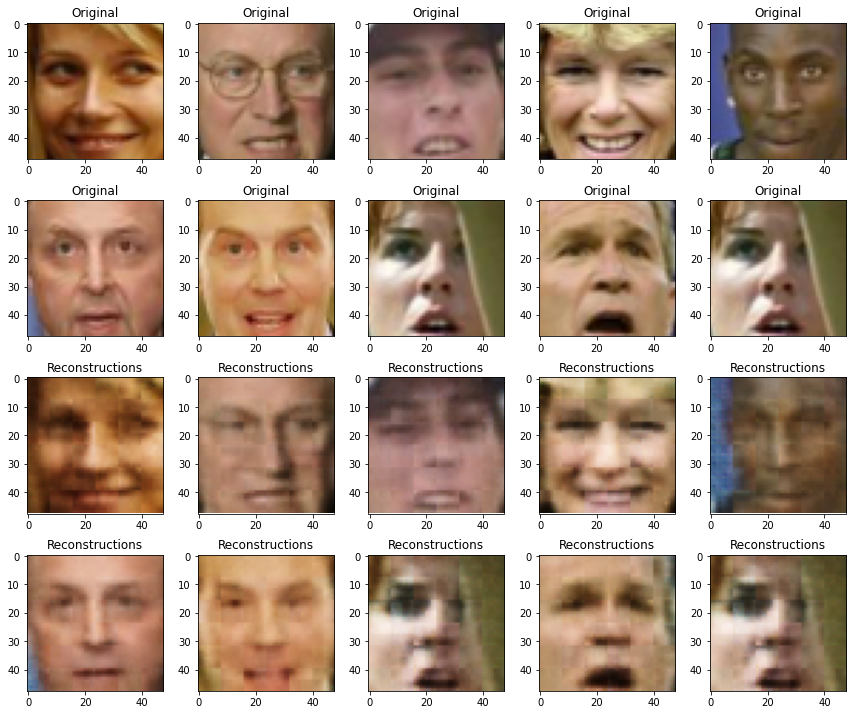

In [21]:
draw_epoch_result(val_dataloader, autoencoder, idx=0, samples=20, cols=5)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 62.22it/s]


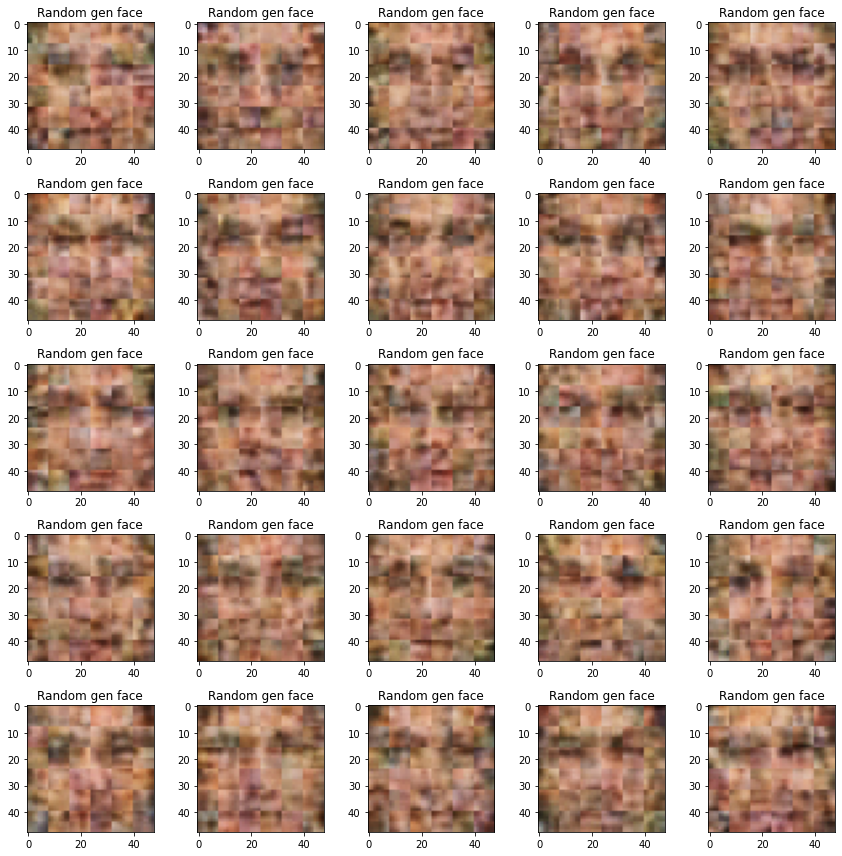

In [22]:
# сгенерируем 25 рандомных векторов размера latent_space
def visualize_random_gen_face(outs, idx=0, samples=25, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        ax.ravel()[i].imshow(outs[i].permute(1,2,0).detach().cpu().numpy())
        ax.ravel()[i].set_title(f'Random gen face')
    plt.tight_layout()
    plt.show()

def get_std_and_mean_from_latent_vectors(model, loader):
    model.eval()
    stream = tqdm(loader)
    outs = []
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(params['device'], non_blocking=False)
            latent_vector = model.encoder(image)
            outs.append(latent_vector.detach().cpu().numpy())
    outs = np.concatenate(outs)
    mean = np.mean(outs, axis=0)
    std = np.std(outs, axis=0)
    return mean, std
    
mean, std = get_std_and_mean_from_latent_vectors(autoencoder, val_dataloader)
z = torch.tensor(mean + std*np.random.randn(25, 64, 6, 6), dtype=torch.float32).to(params['device'])
output = autoencoder.decoder(z)
visualize_random_gen_face(output)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

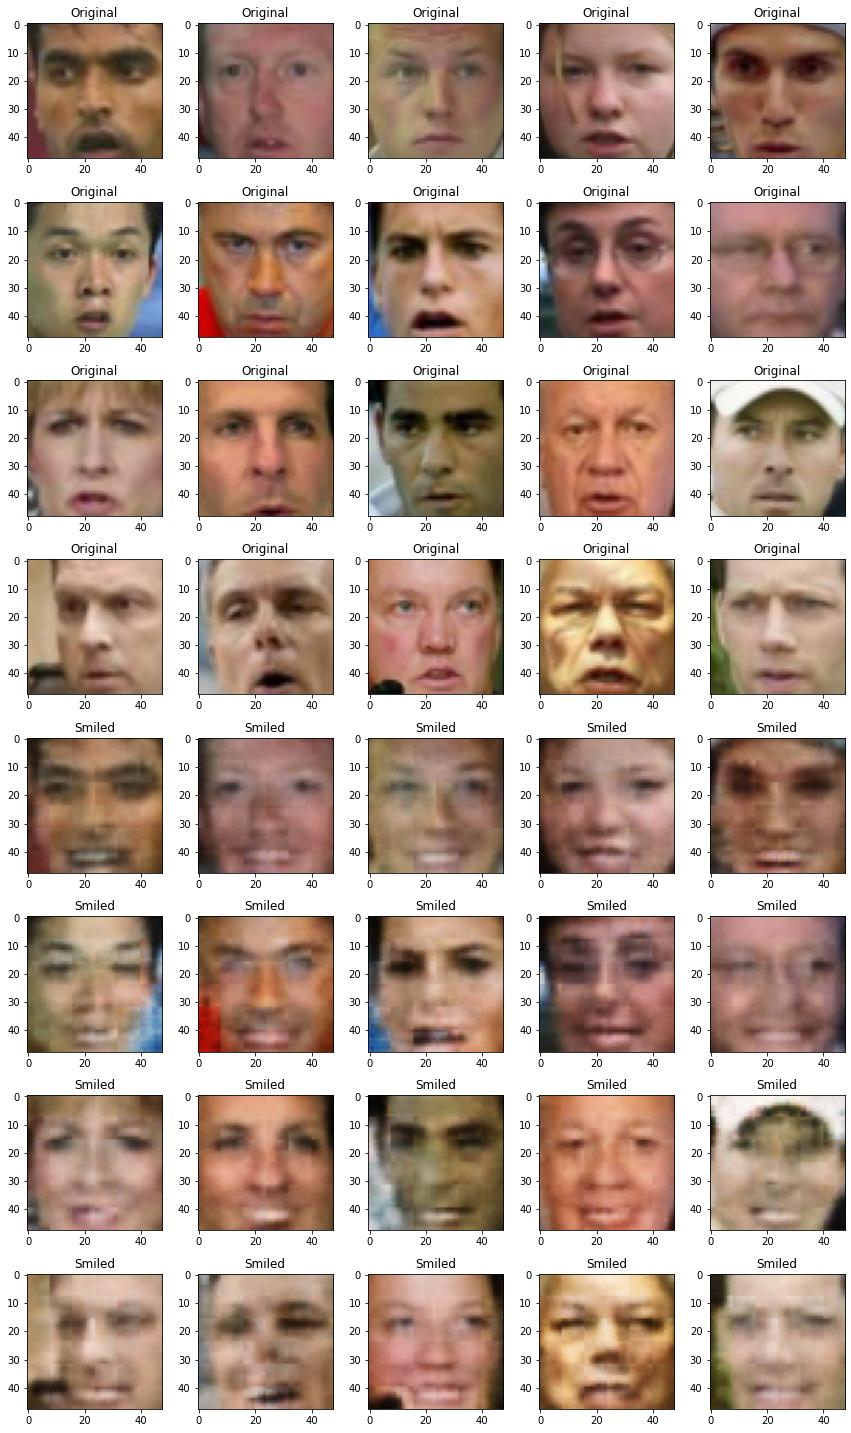

In [23]:
def visualize_angry_to_smile(indexes, images, idx=0, samples=20, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(len(indexes)):
        ax.ravel()[i].imshow(data[indexes[i]])
        ax.ravel()[i+samples//2].imshow(images[i])
        ax.ravel()[i].set_title('Original')
        ax.ravel()[i+samples//2].set_title('Smiled')
    plt.tight_layout()
    plt.show()
    
def encode_smile_and_not(model, smile_idx, non_smile_idx):
    model.eval()
    smile_latent_vectors = []
    not_smile_laent_vectors = []
    with torch.no_grad():
        for i, j in zip(smile_idx, non_smile_idx):
            image = train_dataset.transform(image=data[i])['image']
            image = image.type(torch.FloatTensor).to(params['device'], non_blocking=False).unsqueeze(0)
            latent_vector = model.encoder(image)
            smile_latent_vectors.append(latent_vector.detach().cpu().numpy())
            image = train_dataset.transform(image=data[j])['image']
            image = image.type(torch.FloatTensor).to(params['device'], non_blocking=False).unsqueeze(0)
            latent_vector = model.encoder(image)
            not_smile_laent_vectors.append(latent_vector.detach().cpu().numpy())
    smile_latent_vectors = np.concatenate(smile_latent_vectors)
    not_smile_laent_vectors = np.concatenate(not_smile_laent_vectors)
    smile_vector = np.mean(smile_latent_vectors, axis=0) - np.mean(not_smile_laent_vectors, axis=0)
    return torch.tensor(smile_vector, dtype=torch.float32).to(params['device'])

def decode_smile(model, non_smile_idx, smile_vector):
    recs = []
    model.eval()
    with torch.no_grad():
        for i in non_smile_idx:
            image = train_dataset.transform(image=data[i])['image']
            image = image.type(torch.FloatTensor).to(params['device'], non_blocking=False).unsqueeze(0)
            latent_vector = model.encoder(image)
            new_vector = latent_vector + smile_vector
            reconstruction = model.decoder(new_vector)
            recs.append(reconstruction.squeeze(0).permute(1,2,0).detach().cpu().numpy())
    return recs

# Сортировка в порядке увеличения улыбки
idx = attrs.Smiling.sort_values().index 
# Беру 200 людей с улыбкой и 200 без улыбки
smile_idx = list(idx[-200:])
non_smile_idx = list(idx[:200])
smile_vector = encode_smile_and_not(autoencoder, smile_idx, non_smile_idx)
new_images = decode_smile(autoencoder, non_smile_idx[:20], smile_vector)
visualize_angry_to_smile(non_smile_idx[:20], new_images, samples=40)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

In [24]:
# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=False, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.Resize((32, 32)),
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=True)

# download and transform val dataset
val_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=False, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.Resize((32, 32)),
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])), 
                                           batch_size=64, 
                                           shuffle=False)

###### Здесь, в VAE для датасета MNIST беру z_dim = 64

In [31]:
class VAE(nn.Module):
    def __init__(self, input_channel=1, init_channels=8, kernel_size=4, z_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Linear(64, 128)
        self.mu = nn.Linear(128, z_dim)
        self.logvar = nn.Linear(128, z_dim)
        self.fc2 = nn.Linear(z_dim, 64)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(init_channels*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=input_channel, kernel_size=kernel_size, stride=2, padding=1),
            nn.Sigmoid()
            )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        mu, logvar = self.mu(x), self.logvar(x)
        return mu, logvar
    
    def gaussian_sampler(self, mu, logvar, flag):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        if flag:
            z = mu + std * eps 
            return z
        else:
            return mu
    
    def decode(self, z):
        z = z.view(-1, 64, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, train=True):
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar, train)
        z = self.fc2(z)
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [32]:
def KL_divergence(mu, logvar):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
#     print(mu.shape, 'KL')
    loss = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar)) # <напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
#     print(x.shape, 'BCE')
    loss = torch.nn.BCELoss(reduction='sum') # <binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logvar, reconstruction):
    return (KL_divergence(mu, logvar) + log_likelihood(x, reconstruction))/x.size(0) # <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [33]:
vae = VAE().to(params['device'])
criterion = loss_vae
optimizer = torch.optim.Adam(vae.parameters())
# summary(vae, (1, 32, 32))

In [34]:
# <обучите модель, как и autoencoder, но на датасете MNIST>
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    for i, (image, attr) in enumerate(stream, start=1):
        image = image.to(device, non_blocking=False)
        optimizer.zero_grad()
        mu, logvar, output = model(image, train=True)
        loss = criterion(image, mu, logvar, output)
        loss.backward()
        optimizer.step()
        metric_monitor.update("Loss", loss.item())
        running_loss += loss.item()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=False)
            mu, logvar, output = model(image, train=False)
            loss = criterion(image, mu, logvar, output)
            metric_monitor.update("Loss", loss.item())
            running_loss += loss.item()
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    epoch_loss = running_loss/len(val_loader)
    return epoch_loss
    
def draw_epoch_result(val_loader, model, idx=0, samples=10, cols=5):
    images, _ = next(iter(val_loader))
    idxes = np.random.randint(0, len(images), samples//2)
    images = images[idxes,]
    model.eval()
    with torch.no_grad():
        _, _, recosntructions = model(images.to(params["device"]), train=False)
    clear_output(wait=True)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples//2):
        ax.ravel()[i].imshow(images[i].permute(1,2,0).cpu().numpy(), cmap='gray')
        ax.ravel()[i+samples//2].imshow(recosntructions[i].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
        ax.ravel()[i].set_title('Original')
        ax.ravel()[i+samples//2].set_title('Reconstructions')
    plt.tight_layout()
    plt.show()

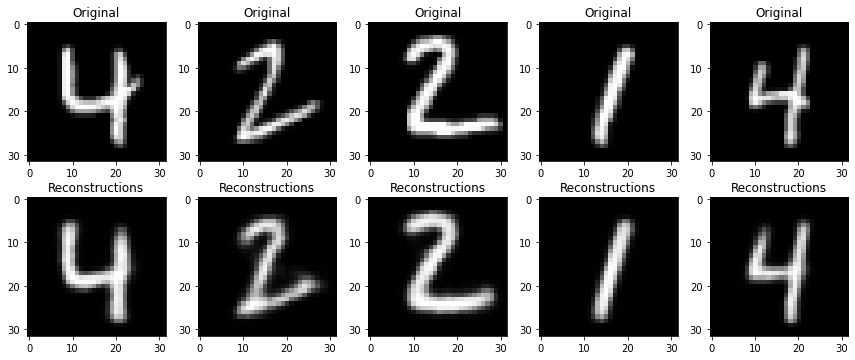

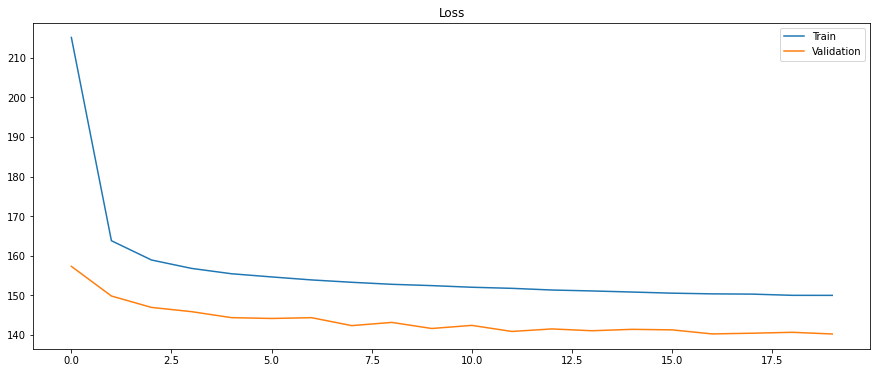

In [35]:
main_loop(train_loader, val_loader, vae, criterion, optimizer, params['epochs'], params['device'])

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

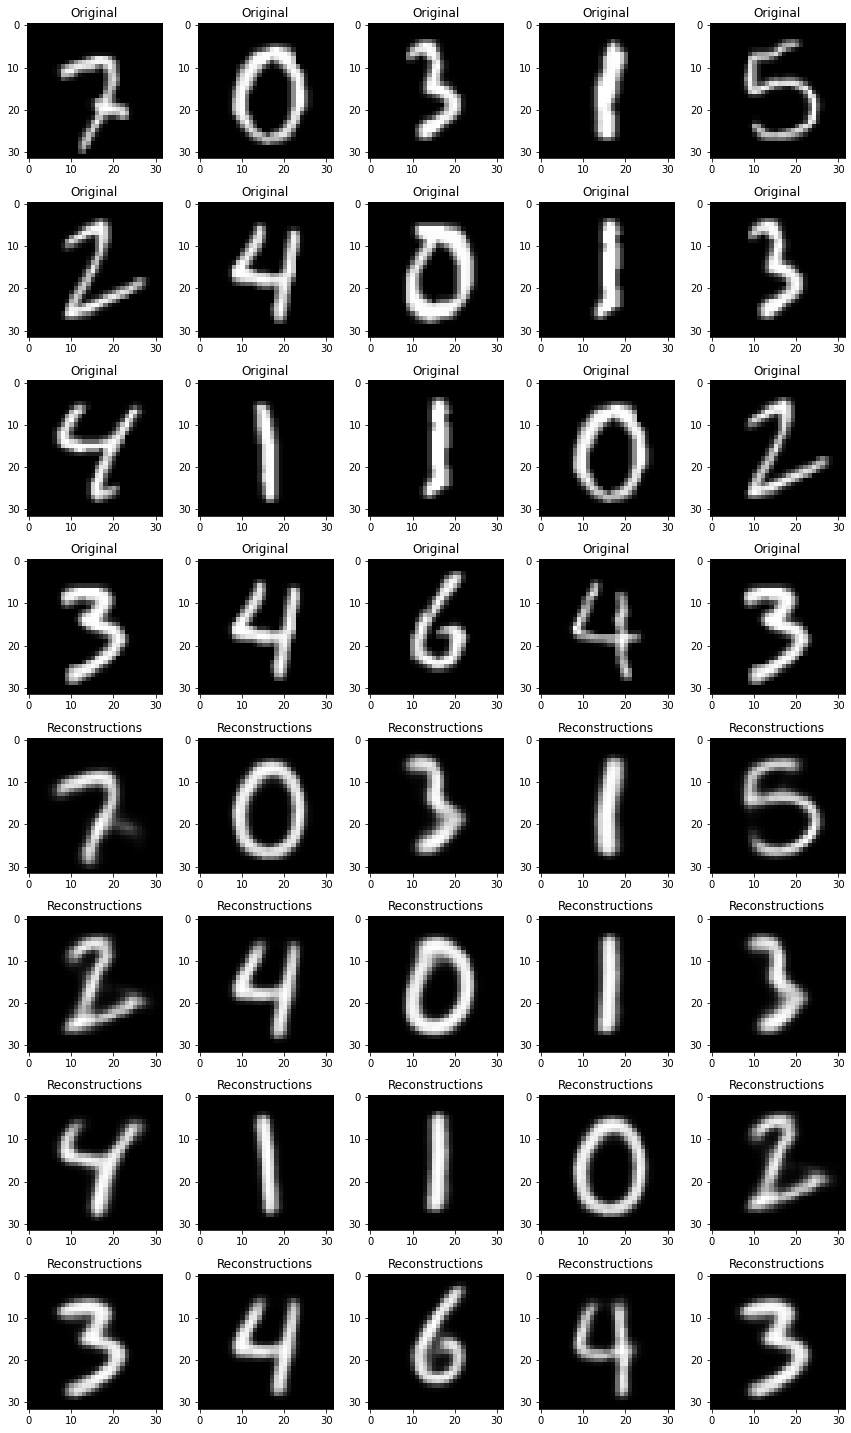

In [36]:
draw_epoch_result(val_loader, vae, idx=0, samples=40, cols=5)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 115.88it/s]


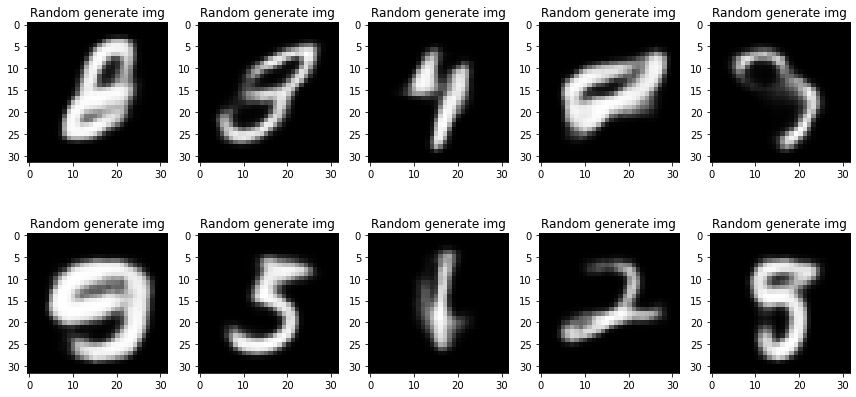

In [40]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
def visualize_sampling_vae(outs, idx=0, samples=20, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        ax.ravel()[i].imshow(outs[i].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
        ax.ravel()[i].set_title(f'Random generate img')
    plt.tight_layout()
    plt.show()
    
def get_mean_std_of_latent_vector(model, val_loader):
    model.eval()
    stream = tqdm(val_loader)
    outs = []
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(params['device'], non_blocking=False)
            mu, logvar = model.encode(image)
            latent_vector = model.gaussian_sampler(mu, logvar, False)
            outs.append(latent_vector.detach().cpu().numpy())
    outs = np.concatenate(outs)
    mean = np.mean(outs, axis=0)
    std = np.std(outs, axis=0)
    return mean, std

def decode_random(z):
    z = vae.fc2(z)
    output = vae.decode(z)
    return output

# mean, std = get_mean_std_of_latent_vector(vae, val_loader)
# z = torch.tensor(mean + std*np.random.randn(10, 64), dtype=torch.float32).to(params['device'])
z = torch.tensor(np.random.randn(10, 64), dtype=torch.float32).to(params['device'])
output = decode_random(z)
visualize_sampling_vae(output, samples=10)

###### Видно, что выше на рисунке часто попадаем в зазоры, чтобы получить более-менее что-то вменяемое, надо получить распределение конкретной цифры и сэмплить уже из этой области

## Latent Representation

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 107.88it/s]


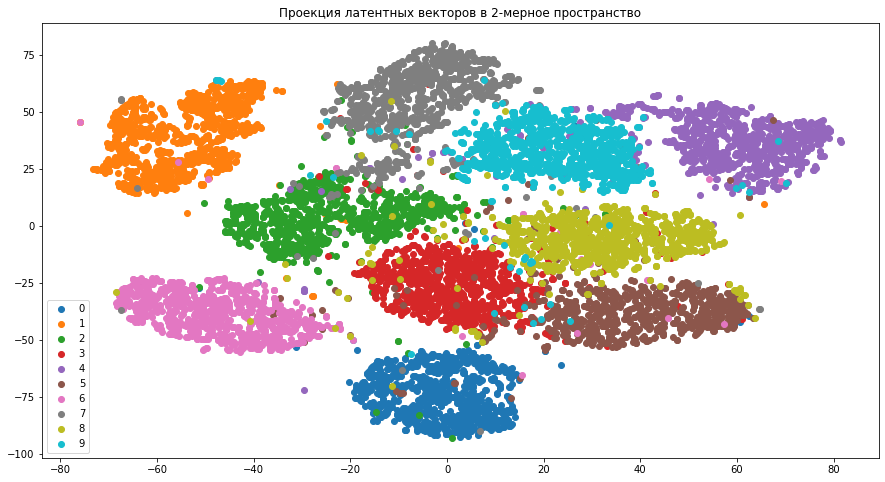

In [41]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
def get_latent_vector(model, val_loader):
    model.eval()
    stream = tqdm(val_loader)
    outs = []
    labels = []
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(params['device'], non_blocking=False)
            mu, logvar = model.encode(image)
            latent_vector = model.gaussian_sampler(mu, logvar, False)
            outs.append(latent_vector.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
    outs = np.concatenate(outs)
    labels = np.concatenate(labels)
    return outs, labels

latent_vectors, labels = get_latent_vector(vae, val_loader)
X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)
visualize_tsne(X_embedded, labels)

Что вы думаете о виде латентного представления?
- Кластеры находятся отдалены друг от друга, хоть и не сильно, виден плавный переход от одной цифры к другой, но не везде.

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [44]:
# <тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>
class CVAE(nn.Module):
    def __init__(self, input_channel=1, init_channels=8, kernel_size=4, z_dim=64, n_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Linear(64, 128)
        self.mu = nn.Linear(128+n_classes, z_dim)
        self.logvar = nn.Linear(128+n_classes, z_dim)
        self.fc2 = nn.Linear(z_dim+n_classes, 64)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(init_channels*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=input_channel, kernel_size=kernel_size, stride=2, padding=1),
            nn.Sigmoid()
            )
    
    def encode(self, x, ohe):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.cat([x, ohe], dim=1)
        mu, logvar = self.mu(x), self.logvar(x)
        return mu, logvar
    
    def gaussian_sampler(self, mu, logvar, flag):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        if flag:
            z = mu + std * eps 
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, ohe):
        z = torch.cat([z, ohe], dim=1)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, ohe, train=True):
        mu, logvar = self.encode(x, ohe)
        z = self.gaussian_sampler(mu, logvar, train)
        reconstruction = self.decode(z, ohe)
        return mu, logvar, reconstruction

In [45]:
cvae = CVAE().to(params['device'])
criterion = loss_vae
optimizer = torch.optim.Adam(cvae.parameters())
# summary(autoencoder, (1,32,32))

In [46]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    for i, (image, target) in enumerate(stream, start=1):
        ohe = F.one_hot(target, num_classes=10).to(device)
        image = image.to(device, non_blocking=False)
        optimizer.zero_grad()
        mu, logvar, output = model(image, ohe, train=True)
        loss = criterion(image, mu, logvar, output)
        loss.backward()
        optimizer.step()
        metric_monitor.update("Loss", loss.item())
        running_loss += loss.item()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            ohe = F.one_hot(target, num_classes=10).to(device)
            image = image.to(device, non_blocking=False)
            mu, logvar, output = model(image, ohe, train=True)
            loss = criterion(image, mu, logvar, output)
            metric_monitor.update("Loss", loss.item())
            running_loss += loss.item()
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    epoch_loss = running_loss/len(val_loader)
    return epoch_loss
    
def draw_epoch_result(val_loader, model, idx=0, samples=10, cols=5):
    images, labels = next(iter(val_loader))
    idxes = np.random.randint(0, len(images), samples//2)
    images = images[idxes,]
    ohe = F.one_hot(labels[idxes,], num_classes=10).to(params["device"])
    model.eval()
    with torch.no_grad():
        _, _, recosntructions = model(images.to(params["device"]), ohe, train=False)
    clear_output(wait=True)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples//2):
        ax.ravel()[i].imshow(images[i].permute(1,2,0).cpu().numpy(), cmap='gray')
        ax.ravel()[i+samples//2].imshow(recosntructions[i].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
        ax.ravel()[i].set_title('Original')
        ax.ravel()[i+samples//2].set_title('Reconstructions')
    plt.tight_layout()
    plt.show()

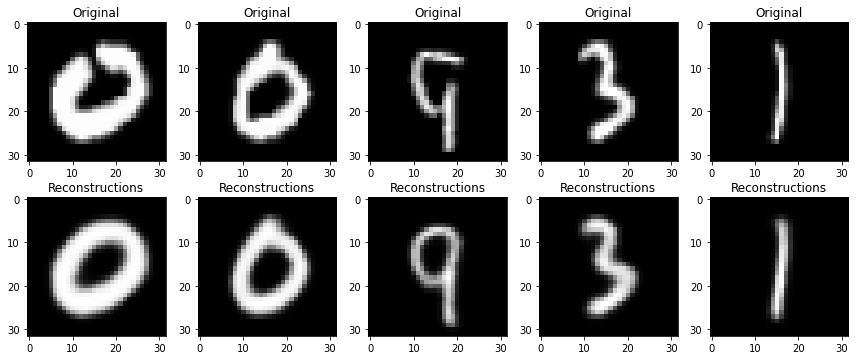

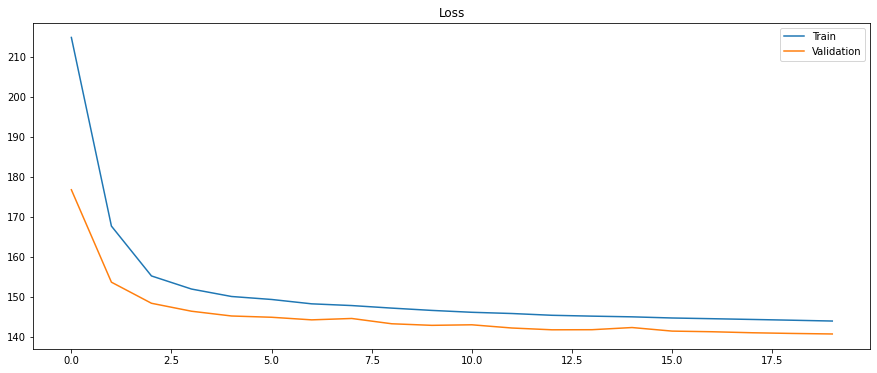

In [47]:
main_loop(train_loader, val_loader, cvae, criterion, optimizer, params['epochs'], params['device'])

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

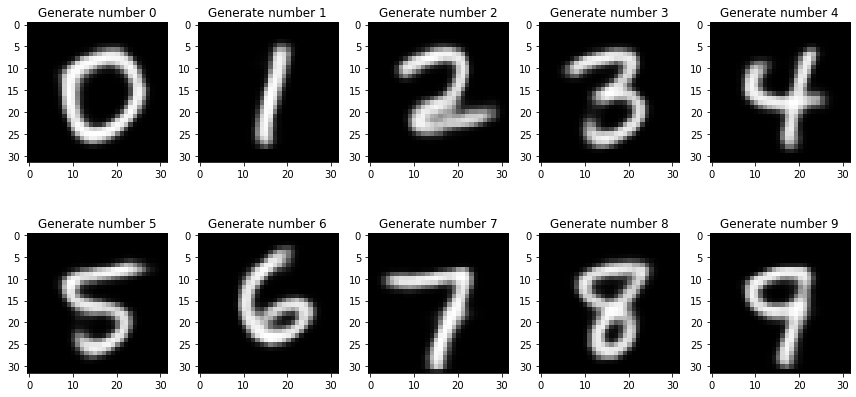

In [63]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
def visualize_sampling_cvae(outs, idx=0, samples=20, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        ax.ravel()[i].imshow(outs[i].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
        ax.ravel()[i].set_title(f'Generate number {i}')
    plt.tight_layout()
    plt.show()

def decode_random(z, ihe):
    output = cvae.decode(z, ohe)
    return output

random_vector = np.random.randn(1, 64)
latent = np.zeros((10, 64))
for i in range(len(latent)):
    latent[i] = random_vector
ohe = F.one_hot(torch.tensor([i for i in range(10)]), 10).to(params['device'])
z = torch.tensor(latent, dtype=torch.float32).to(params['device'])
output = decode_random(z, ohe)
visualize_sampling_cvae(output, samples=10)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 90.47it/s]


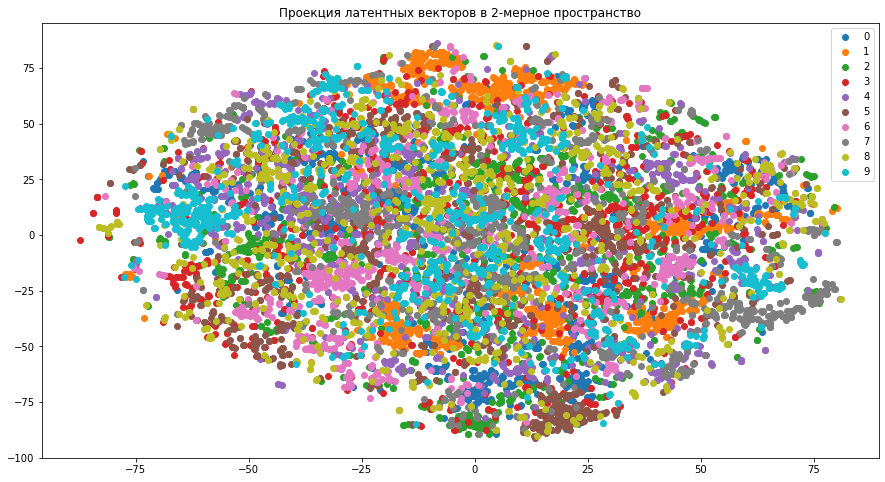

In [64]:
def get_latent_vector(model, val_loader):
    model.eval()
    stream = tqdm(val_loader)
    outs = []
    labels = []
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(params['device'], non_blocking=False)
            ohe = F.one_hot(target, num_classes=10).to(params['device'])
            mu, logvar = model.encode(image, ohe)
            latent_vector = model.gaussian_sampler(mu, logvar, False)
            outs.append(latent_vector.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
    outs = np.concatenate(outs)
    labels = np.concatenate(labels)
    return outs, labels

latent_vectors, labels = get_latent_vector(cvae, val_loader)
X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)
visualize_tsne(X_embedded, labels)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?
- Картинка сильно отличается от обычного VAE, кластеры хоть и наложены друг на друга, но не сильно рандомно, все-таки сгустки скоплений кластеров имеется 

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

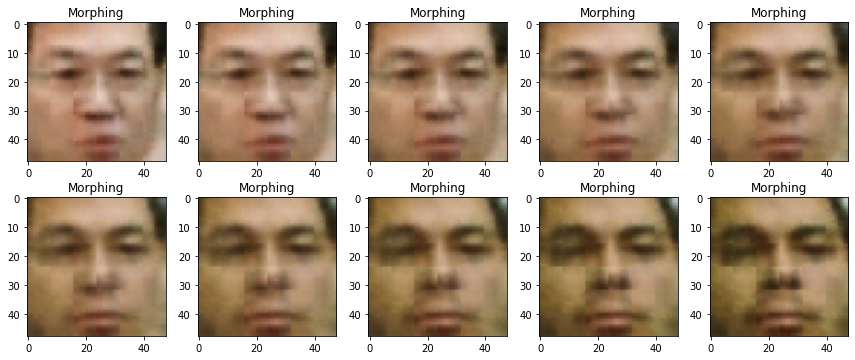

In [65]:
def visualize_morphing(images, idx=0, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples):
        ax.ravel()[i].imshow(images[i])
        ax.ravel()[i].set_title('Morphing')
    plt.tight_layout()
    plt.show()

def morphing(model, idx):
    recs, lats, result = [], [], []
    alphas = np.arange(0, 1.1, 0.1)
    model.eval()
    with torch.no_grad():
        for i in idx:
            image = train_dataset.transform(image=data[i])['image']
            image = image.type(torch.FloatTensor).to(params['device'], non_blocking=False).unsqueeze(0)
            latent_vector = model.encoder(image)
            lats.append(latent_vector)
        for alpha in alphas:
            result_vector = alpha * lats[0] + (1-alpha) * lats[1]
            result.append(result_vector)
        for vector in result:
            reconstruction = model.decoder(vector)
            recs.append(reconstruction.squeeze(0).permute(1,2,0).detach().cpu().numpy())
    return recs

idx = np.random.randint(0, len(data), 2)
recs = morphing(autoencoder, idx)
visualize_morphing(recs)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [66]:
autoencoder_noize = Autoencoder().to(params["device"])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder_noize.parameters())
NOIZE = 0.2

In [67]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    for i, (image, attr) in enumerate(stream, start=1):
        image = image.to(device, non_blocking=False)
        noise_image = image + NOIZE*torch.randn_like(image).to(device)
        optimizer.zero_grad()
        output, _ = model(noise_image)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        metric_monitor.update("Loss", loss.item())
        running_loss += loss.item()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=False)
            noise_image = image + NOIZE*torch.randn_like(image).to(device)
            output, _ = model(noise_image)
            loss = criterion(output, image)
            metric_monitor.update("Loss", loss.item())
            running_loss += loss.item()
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    epoch_loss = running_loss/len(val_loader)
    return epoch_loss
    
def draw_epoch_result(val_loader, model, idx=0, samples=15, cols=5):
    images, _ = next(iter(val_loader))
    idxes = np.random.randint(0, len(images), samples//3)
    images = images[idxes,]
    model.eval()
    with torch.no_grad():
        noise_images = images + NOIZE*torch.randn_like(images)
        recosntructions, _ = model(noise_images.to(params["device"]))
    noise_images = torch.clip(noise_images, 0, 1)
    clear_output(wait=True)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples//3):
        ax.ravel()[i].imshow(noise_images[i].permute(1, 2, 0).cpu().numpy())
        ax.ravel()[i+samples//3].imshow(recosntructions[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.ravel()[i+samples-cols].imshow(images[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.ravel()[i].set_title('Noise')
        ax.ravel()[i+samples//3].set_title('Reconstructions')
        ax.ravel()[i+samples-cols].set_title('Original')
    plt.tight_layout()
    plt.show()

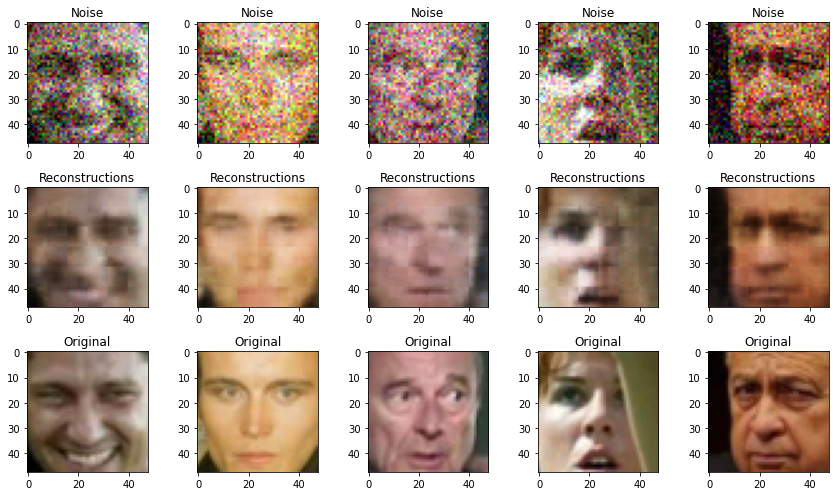

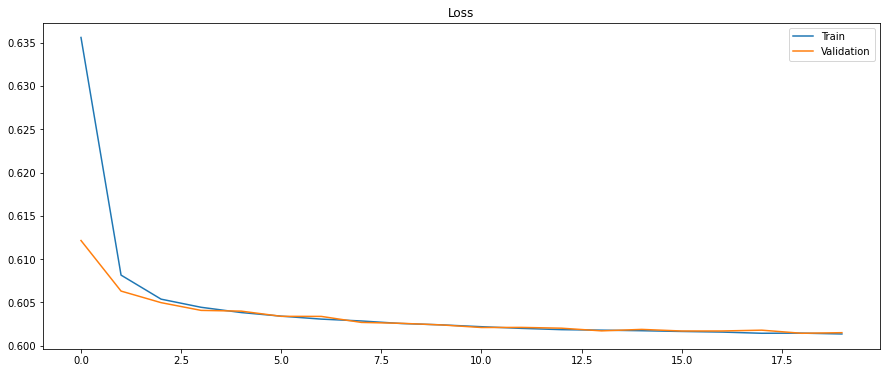

In [68]:
main_loop(train_dataloader, val_dataloader, autoencoder_noize, criterion, optimizer, params["epochs"], params["device"])

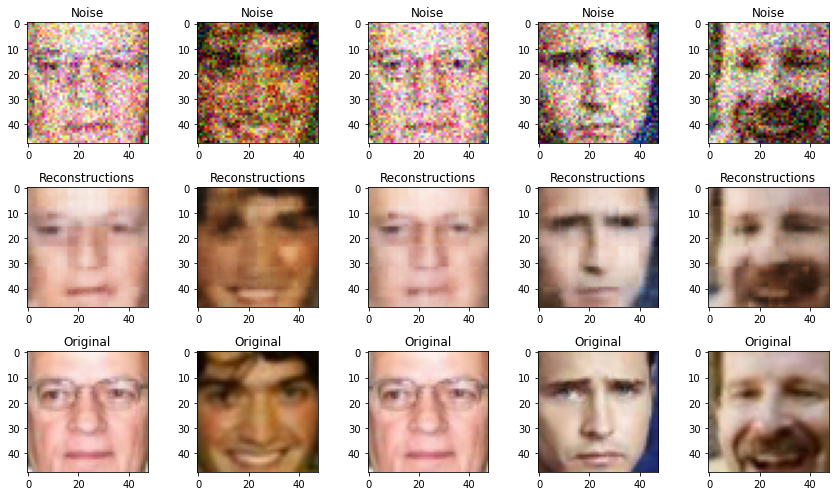

In [74]:
draw_epoch_result(val_dataloader, autoencoder_noize, samples=15)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [106]:
autoencoder_occluded = Autoencoder().to(params["device"])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder_occluded.parameters())

def crop(image, length=5):
    center_pixel = (np.random.randint(5, 43), np.random.randint(5, 43))
    image = deepcopy(image)
    image[:, :, center_pixel[0]:center_pixel[0]+5, center_pixel[1]:center_pixel[1]+5] = 1
    return image

In [107]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    for i, (image, attr) in enumerate(stream, start=1):
        occluded_image = crop(image)
        image = image.to(device, non_blocking=False)
        occluded_image = occluded_image.to(device, non_blocking=False)
        optimizer.zero_grad()
        output, _ = model(occluded_image)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        metric_monitor.update("Loss", loss.item())
        running_loss += loss.item()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            occluded_image = crop(image)
            image = image.to(device, non_blocking=False)
            occluded_image = occluded_image.to(device, non_blocking=False)
            output, _ = model(occluded_image)
            loss = criterion(output, image)
            metric_monitor.update("Loss", loss.item())
            running_loss += loss.item()
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    epoch_loss = running_loss/len(val_loader)
    return epoch_loss
    
def draw_epoch_result(val_loader, model, idx=0, samples=15, cols=5):
    images, _ = next(iter(val_loader))
    idxes = np.random.randint(0, len(images), samples//3)
    images = images[idxes,]
    model.eval()
    with torch.no_grad():
        occluded_image = crop(images)
        recosntructions, _ = model(occluded_image.to(params["device"]))
    clear_output(wait=True)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, samples//2))
    for i in range(samples//3):
        ax.ravel()[i].imshow(occluded_image[i].permute(1, 2, 0).cpu().numpy())
        ax.ravel()[i+samples//3].imshow(recosntructions[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.ravel()[i+samples-cols].imshow(images[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.ravel()[i].set_title('Occluded')
        ax.ravel()[i+samples//3].set_title('Reconstructions')
        ax.ravel()[i+samples-cols].set_title('Original')
    plt.tight_layout()
    plt.show()

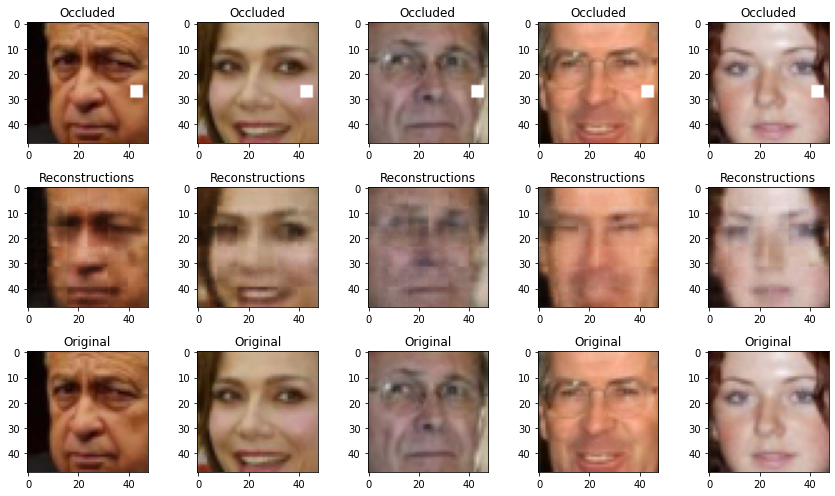

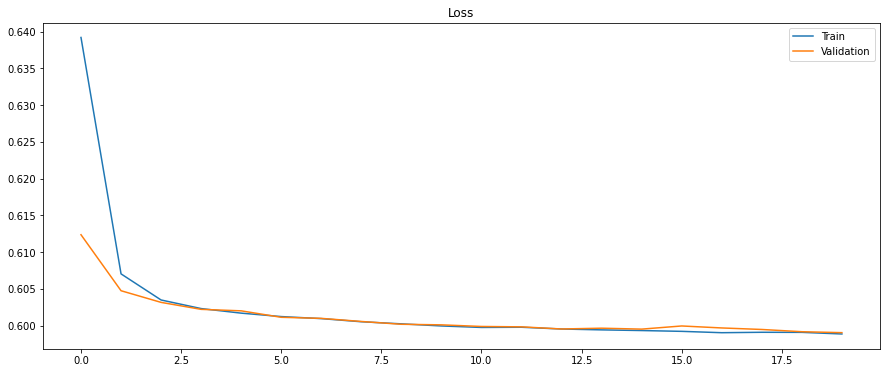

In [108]:
main_loop(train_dataloader, val_dataloader, autoencoder_occluded, criterion, optimizer, params["epochs"], params["device"])

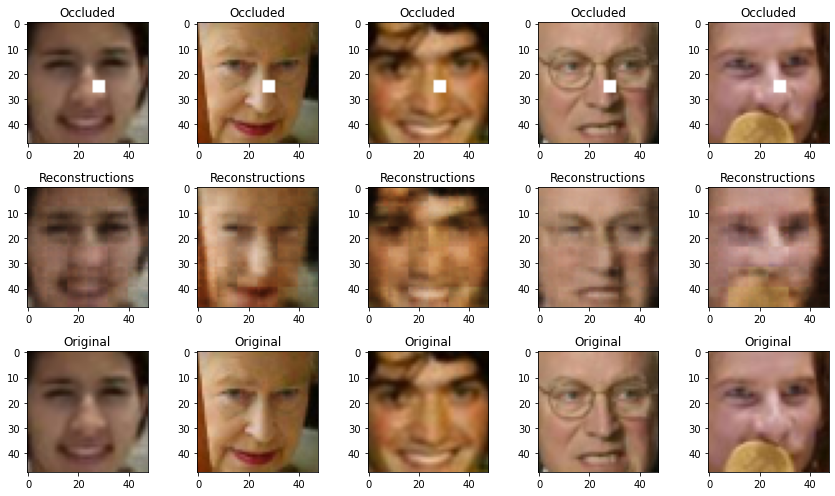

In [109]:
draw_epoch_result(val_dataloader, autoencoder_occluded, samples=15)

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [149]:
def get_codes(model, train_imgs):
    model.eval()
    stream = tqdm(train_imgs)
    outs = []
    with torch.no_grad():
        for i, (image) in enumerate(stream, start=1):
            image = train_dataset.transform(image=image)['image'].unsqueeze(0)
            image = image.to(torch.float32).to(params['device'], non_blocking=False)
            output = model.encoder(image)
            outs.append(output.detach().cpu().numpy().reshape(output.size(0), -1))
    outs = np.concatenate(outs)
    return outs

def get_one_code(model, image):
    model.eval()
    with torch.no_grad():
        image = train_dataset.transform(image=image)['image'].unsqueeze(0)
        image = image.to(torch.float32).to(params['device'], non_blocking=False)
        output = model.encoder(image)
    out = output.detach().cpu().numpy().reshape(output.size(0), -1)
    return out

codes = get_codes(autoencoder, train_imgs)

In [143]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors(n_neighbors=11).fit(codes)

In [144]:
def get_similar(image):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

    code = get_one_code(autoencoder, image)

    (distances,),(idx,) = lshf.kneighbors(code)

    return distances, train_imgs[idx]

In [156]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image)
    
    plt.figure(figsize=[20,12])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

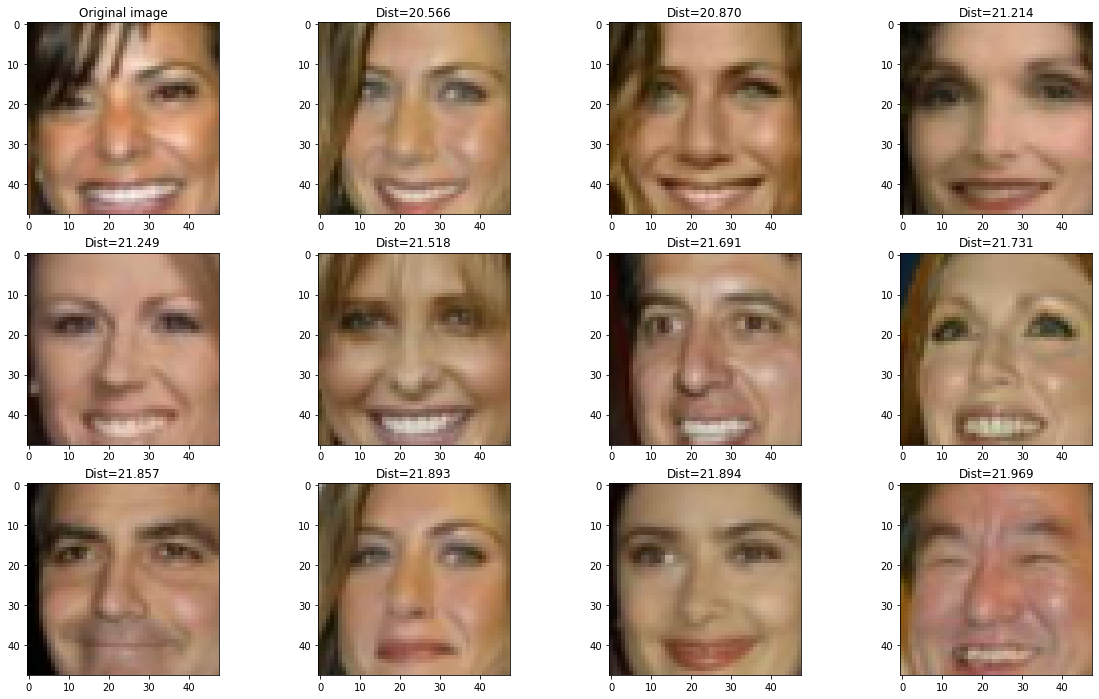

In [160]:
image = val_imgs[2]
show_similar(image)